In [1]:
import sys
sys.path.insert(1, './..')

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from matplotlib.patches import Rectangle
from math import prod
from tqdm import tqdm

import spark
from spark.nn.interfaces import (PoissonSpiker, LinearSpiker, TopologicalPoissonSpiker, TopologicalLinearSpiker,
                                 ExponentialIntegrator, Merger, Sampler)
from spark.nn.components import SimpleSynapses, TracedSynapses, NDelays, N2NDelays, ALIFSoma
from spark.nn.neurons import ALIFNeuron
from spark import SpikeArray, CurrentArray, FloatArray, Variable, Constant, IntegerArray
from spark.core.specs import ModuleSpecs, PortSpecs, PortMap

In [ ]:
np.

In [3]:
# Note that the input map can be see as the output of a virtual node (the environment.)
input_map = {
    'drive': PortSpecs(payload_type=FloatArray, shape=(4,), dtype=jnp.float16)
}
output_map = {
    'integrator': {
        'output': PortSpecs(payload_type=FloatArray, shape=(2,), dtype=jnp.float16)
	}
}
modules_map = {
   'spiker': ModuleSpecs(
        name ='spiker', 
		module_cls = TopologicalLinearSpiker, 
		inputs = {
        	'drive': [
                PortMap(origin='__call__', port='drive'),
        	]
    	},
		init_args = {
            'input_shape':(4,), 
			'glue': jnp.array(0), 
			'mins': jnp.array(-1),  
			'maxs': jnp.array(1), 
			'resolution': 128, 
			'max_freq': 200.0, 
			'tau': 30.0
		}),
    'A_ex': ModuleSpecs(
        name ='A_ex', 
		module_cls = ALIFNeuron, 
		inputs = {
        	'input_spikes': [
                PortMap(origin='spiker', port='spikes'),
                PortMap(origin='A_ex', port='spikes'),
                PortMap(origin='B_in', port='spikes'),
        	]
    	},
		init_args = {
            'input_shape': (4*128+256+64,), 
			'output_shape': (256,), 
			'synapses_params': {
                'kernel_scale': 3.0
                }, 
			'soma_params': {
				'threshold_tau': 25.0 * jax.random.uniform(jax.random.key(43), shape=(256,), dtype=jnp.float16)**2,
				'threshold_delta': 250.0 * jax.random.uniform(jax.random.key(43), shape=(256,), dtype=jnp.float16)**2,
				'cooldown':2.0,  
			},
			'inhibitory_rate': 0.0,
            'max_delay': 1
		}),
    'A_in': ModuleSpecs(
        name ='A_in', 
		module_cls = ALIFNeuron, 
		inputs = {
        	'input_spikes': [
                PortMap(origin='spiker', port='spikes'),
                PortMap(origin='A_ex', port='spikes'),
        	]
    	},
		init_args = {
            'input_shape': (4*128+256,), 
			'output_shape': (64,), 
			'synapses_params': {
                'kernel_scale': 4.0
                }, 
			'soma_params': {
				'threshold_tau':1.0,
				'threshold_delta':0.0, 
				'cooldown':2.0,  
			},
			'inhibitory_rate': 1.0,
            'max_delay': 1
		}),
	'B_ex': ModuleSpecs(
        name ='B_ex', 
		module_cls = ALIFNeuron, 
		inputs = {
        	'input_spikes': [
                PortMap(origin='spiker', port='spikes'),
                PortMap(origin='B_ex', port='spikes'),
                PortMap(origin='A_in', port='spikes'),
        	]
    	},
		init_args = {
            'input_shape': (4*128+256+64,), 
			'output_shape': (256,), 
			'synapses_params': {
                'kernel_scale': 3.0
                }, 
			'soma_params': {
				'threshold_tau': 25.0 * jax.random.uniform(jax.random.key(42), shape=(256,), dtype=jnp.float16)**2,
				'threshold_delta': 250.0 * jax.random.uniform(jax.random.key(42), shape=(256,), dtype=jnp.float16)**2,
				'cooldown':2.0,  
			},
			'inhibitory_rate': 0.0,
            'max_delay': 1
		}),
	'B_in': ModuleSpecs(
        name ='B_in', 
		module_cls = ALIFNeuron, 
		inputs = {
        	'input_spikes': [
                PortMap(origin='spiker', port='spikes'),
                PortMap(origin='B_ex', port='spikes'),
        	]
    	},
		init_args = {
            'input_shape': (4*128+256,), 
			'output_shape': (64,), 
			'synapses_params': {
                'kernel_scale': 4.0
                }, 
			'soma_params': {
				'threshold_tau':1.0,
				'threshold_delta':0.0, 
				'cooldown':2.0,  
			},
			'inhibitory_rate': 1.0,
            'max_delay': 1
		}),
	'integrator': ModuleSpecs(
        name ='integrator', 
		module_cls = ExponentialIntegrator, 
		inputs = {
        	'input_spikes': [
                PortMap(origin='A_ex', port='spikes'),
                PortMap(origin='B_ex', port='spikes'),
        	]
    	},
		init_args = {
            'input_shape': (256+256,), 
			'output_dim': 2
		}),
}

brain = spark.Brain(input_map=input_map, output_map=output_map, modules_map=modules_map)

KeyboardInterrupt: 

In [ ]:
asd = {'a':1, 'b':1, 'c':1}
for v in asd.keys():
    asd[v] += 1
print(asd)

{'a': 2, 'b': 2, 'c': 2}


In [ ]:
@jax.jit
def run_model(graph, state, x):
	model = nnx.merge(graph, state)
	out, spikes = model(drive=x)
	_, state = nnx.split((model))
	return out, spikes, state

def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

100%|██████████| 100/100 [00:01<00:00, 62.82it/s]


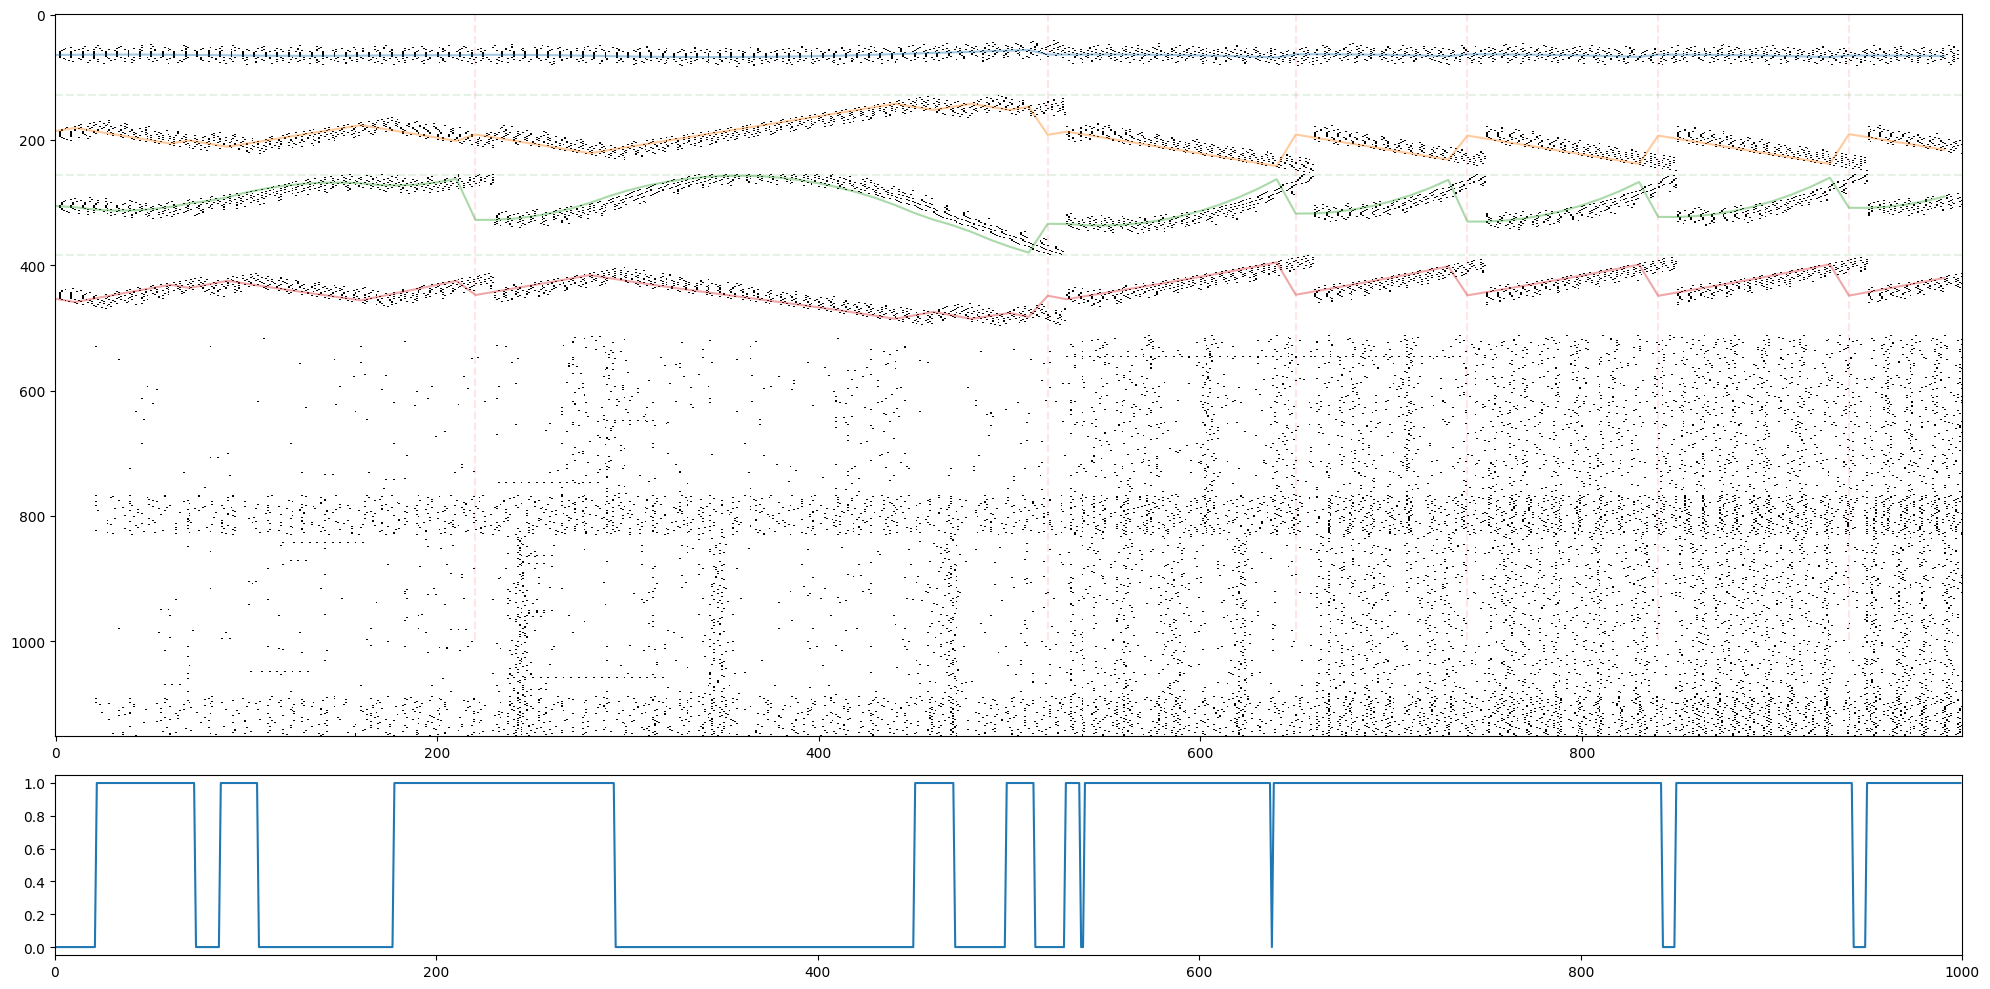

In [ ]:
import time
import gymnasium as gym
import ale_py
import numpy as np
gym.register_envs(ale_py)

env_name =  'CartPole-v1'

env = gym.make(env_name)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

model = spark.Brain(input_map=input_map, output_map=output_map, modules_map=modules_map)
model(drive=FloatArray(jnp.zeros((4,), dtype=jnp.float16)))
graph, state = nnx.split((model))
#starting_kernel = model.neurons.synapses.get_flat_kernel()
brain_steps_per_env_step = 10

if False:
	reward = 0
	reward_array = []
	for i in tqdm(range(5000)):
		prev_obs = next_obs
		# Model logic
		out, model_spikes, state = run_model(graph, state, FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		# Environment logic.
		next_action = int(np.argmax(out['integrator.output'].value))
		next_obs, _, terminated, truncated, info = env.step(next_action)
		if terminated:
			next_obs, _ = env.reset()
			# Flush model
			for i in range(16):
				_, _, state = run_model(graph, state, FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
		next_obs = process_obs(next_obs)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		reward_array.append(reward)

outs = []
spikes = []
obs = []
breaks = []
break_obs = []
actions = []
reward = 0
next_obs, _ = env.reset(seed=42+1)
next_obs = process_obs(next_obs)
for i in tqdm(range(100)):
	prev_obs = next_obs
	# Model logic
	for _ in range(brain_steps_per_env_step):
		out, model_spikes, state = run_model(graph, state, FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		outs.append(out['integrator.output'].value)
		spikes.append(jnp.concatenate([s.value.reshape(-1) for s in model_spikes]))
		# Environment logic.
		next_action = int(np.argmax(out['integrator.output'].value))
		actions.append(next_action)
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		break_obs.append(next_obs)
		next_obs, _ = env.reset()
		breaks.append(brain_steps_per_env_step*i)
		# Flush model
		for i in range(50):
			_, _, state = run_model(graph, state, FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	obs.append(next_obs)
	
model = nnx.merge(graph, state)

spikes = np.abs(np.array(spikes))
fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,len(spikes)-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[0]+64, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[1]+64+128, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[2]+64+256, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(actions)
ax[1].set_xlim(0, len(actions))
plt.tight_layout()
plt.show()
if False:
	plt.imshow(starting_kernel, aspect='auto', interpolation='none')
	plt.colorbar()
	plt.show()
	plt.imshow(final_kernel, aspect='auto', interpolation='none')
	plt.colorbar()
	plt.show()

In [9]:
# Add QT to the update loop. 
# Makes the editor non-blocking.
%gui qt
import sys
sys.path.insert(1, './..')

import spark
editor = spark.SparkGraphEditor()
# Start editor on the main thread.
if __name__ == '__main__':
	editor.launch()

In [2]:
input_map, output_map, modules_map = editor.build_model()
model_def = {
	'input_map': input_map,
	'output_map': output_map,
	'modules_map': modules_map,
}
model_def

{'input_map': {'input_0': OutputSpecEditor(payload_type=<class 'spark.core.payloads.FloatArray'>, shape=None, dtype=<class 'jax.numpy.float16'>, description='Model input port.')},
 'output_map': {'output_0': InputSpecEditor(payload_type=<class 'spark.core.payloads.FloatArray'>, shape=None, dtype=<class 'jax.numpy.float16'>, description='Model output port.', is_optional=False, port_maps=[PortMap(origin='0x7d4f14762520', port='signal')])},
 'modules_map': {'PoissonSpiker_0': ModuleSpecsEditor(name='PoissonSpiker_0', module_cls='poisson_spiker', inputs={'signal': [PortMap(origin='__call__', port='value')]}, init_args={}),
  'ALIFNeuron_0': ModuleSpecsEditor(name='ALIFNeuron_0', module_cls='alif_neuron', inputs={'in_spikes': [PortMap(origin='PoissonSpiker_0', port='spikes'), PortMap(origin='ALIFNeuron_0', port='out_spikes')]}, init_args={}),
  'ExponentialIntegrator_0': ModuleSpecsEditor(name='ExponentialIntegrator_0', module_cls='exponential_integrator', inputs={'spikes': [PortMap(origin=

In [2]:
for x in spark.REGISTRY.INITIALIZERS.items():
    print(x)

('constant_delay_initializer', RegistryEntry(name='constant_delay_initializer', class_ref=<function constant_delay_initializer at 0x75bcdcbd6c00>, path=['Initializers', 'Dealy']))
('uniform_delay_initializer', RegistryEntry(name='uniform_delay_initializer', class_ref=<function uniform_delay_initializer at 0x75bcdcbd6ca0>, path=['Initializers', 'Dealy']))
('uniform_kernel_initializer', RegistryEntry(name='uniform_kernel_initializer', class_ref=<function uniform_kernel_initializer at 0x75bcdcbd6e80>, path=['Initializers', 'Kernel']))
('sparse_uniform_kernel_initializer', RegistryEntry(name='sparse_uniform_kernel_initializer', class_ref=<function sparse_uniform_kernel_initializer at 0x75bcdcbd6f20>, path=['Initializers', 'Kernel']))


In [5]:
import sys

sys.path.insert(1, './..')

import spark

from spark.core.configuration import SparkConfig
from spark.nn.initializers.base import Initializer
from spark.nn.initializers.delay import uniform_delay_initializer
import spark.core.validation as validation

In [6]:
from dataclasses import asdict, is_dataclass, fields, field
from typing import Any, Callable
import copy

In [ ]:
class TestCfg(SparkConfig):
	test: Initializer | str = field(
		default=None, 
		metadata={
			'units': None,
			'valid_types': Initializer | str,
			'validators': [
				(lambda x: validation._is_initializer(x) or spark.REGISTRY.INITIALIZERS._exists(x), lambda x: f'test must be a valid initializer, got "{x}".')
			]
		})
	
	#def validate(self):
	#	super().validate()
		
cfg = TestCfg(test='uniform_delay_initializer')
asdict(cfg)

{'seed': None,
 'dtype': jax.numpy.float16,
 'dt': 1.0,
 'test': <function spark.nn.initializers.delay.uniform_delay_initializer(scale: 'int' = 8, dtype: 'int' = <class 'jax.numpy.uint8'>) -> 'Initializer'>}

In [23]:
class MixedConfig(BaseConfig):
    # Auto-promoted simple field
    units = 128
    
    # Explicit field with metadata
    dropout: float = field(
        default=0.2,
        metadata={"ui_type": "slider[0,1]", "description": "Dropout rate"}
    )
    
    # Type-annotated field
    use_batch_norm: bool = True
    
    def validate(self):
        if not 0 <= self.dropout < 1:
            raise ValueError("Dropout must be in [0, 1)")
        
cfg = MixedConfig()
cfg

MixedConfig(dropout=0.2, use_batch_norm=True, units=128)

In [27]:
class InternalConfig(BaseConfig):
    # Complex field with metadata
    kernel_initializer: Callable = field(
        default=lambda x: x+1,
        metadata={
            "ui_type": "function_selector",
            "category": "Initializers",
            "validators": [lambda v: callable(v)]
        }
    )
    
    # Nested configuration
    optimizer_config: BaseConfig = field(
        default_factory=MixedConfig,
        metadata={"ui_type": "nested"}
    )
    
cfg = InternalConfig()
cfg

InternalConfig(kernel_initializer=<function InternalConfig.<lambda> at 0x7bc8dea21bc0>, optimizer_config=MixedConfig(dropout=0.2, use_batch_norm=True, units=128))

In [35]:
for field in fields(cfg):
    print(field.name, field.default)
    print(field.metadata)

dtype float32
{}
seed None
{}
use_amp True
{}
gradient_clip 1.0
{}


In [31]:
class BaseModelConfig(BaseConfig):
    dtype = "float32"
    seed = None

class AdvancedModelConfig(BaseModelConfig):
    # Inherits dtype and seed from base
    use_amp = True
    gradient_clip = 1.0
    
    def validate(self):
        super().validate()
        if self.gradient_clip <= 0:
            raise ValueError("Gradient clip must be positive")
        
cfg = AdvancedModelConfig()
cfg

AdvancedModelConfig(dtype='float32', seed=None, use_amp=True, gradient_clip=1.0)